In [18]:
import networkx as nx
import dependency
import sentence_attentions

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np

from itertools import cycle, islice

from tqdm import tqdm

%matplotlib inline

In [19]:
dev = False
if dev:
    attention_file = '../BertAA/BertAA-dev/attentions.npz'
    token_file = '../BertAA/BertAA-dev/source.txt'
    conllu_file_name = '../graph-extraction/endev.conllu'
    no_softmax = False
else:
    attention_file = '../BertAA/attentions.npz'
    token_file = '../BertAA/source.txt'
    conllu_file_name = '../data/entest.conllu'
    no_softmax = True
    

In [20]:
maxlen = 1000

fontsize=8

#this is necessary in this case
eos =True



dependency_rels = dependency.read_conllu_labeled(conllu_file_name)

with open(token_file) as tokens_file:
    tokens_loaded = [l.split() for l in tokens_file]
    
attentions_loaded = np.load(attention_file)
sentences_count = 1000
layers_count = attentions_loaded['arr_0'].shape[0]
heads_count = attentions_loaded['arr_0'].shape[1]

##  Plot graphs

In [11]:
# for sentence_index, matrices in attention_gen:
#     tokens_list = tokens_loaded[sentence_index]
#     words = ' '.join(tokens_list).replace('@@ ', '')
#     words_list = words.split()# + ['root']
#     if len(words_list) < 16:
#         break

In [21]:
def draw_graphs(layers, heads, threshold,  sentence):
    sentences = [sentence]
    attention_gen = sentence_attentions.generate_matrices(attentions_loaded, tokens_loaded, eos, no_softmax, maxlen,sentences)
    #attention_gen = enumerate(attention_gen)

    viss = {sentence_idx: att_mts for att_mts, sentence_idx in tqdm(attention_gen)}
    
    sentence_index = sentence
    matrices = viss[sentence_index]

    tokens_list = tokens_loaded[sentence_index]
    words = ' '.join(tokens_list).replace('@@ ', '')
    words_list = words.split()# + ['root']
    edge_labeled = {(d, h) : l for d, h, l in dependency_rels[sentence_index]}

    print(sentence_index)
    print(words)

    DG=nx.DiGraph()
    DG.add_edges_from(edge_labeled.keys())

    labels = {}
    for node in DG.nodes():
        labels[node] = words_list[node]
    posG = nx.spring_layout(DG)

    aggr_matrix = np.mean(np.array(matrices)[layers,heads,:,:], axis=0)

    AG = nx.from_numpy_matrix(aggr_matrix, parallel_edges=True, create_using=nx.DiGraph)

    elarge = [(u, v) for (u, v, d) in AG.edges(data=True) if d['weight'] > 0.2]
    weights = [AG[u][v]['weight'] *10 for u,v in elarge]
    posA = nx.spring_layout(AG)



    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))


    nx.draw_networkx_nodes(DG, posG, ax=ax1)
    nx.draw_networkx_edges(DG, posG, ax=ax1)
    nx.draw_networkx_labels(DG, posG,labels, font_size=12, ax=ax1)
    nx.draw_networkx_edge_labels(DG,posG,edge_labels= edge_labeled, font_size=8,font_color='red', ax=ax1)

    nx.draw_networkx_nodes(AG, posA, ax=ax2)
    nx.draw_networkx_edges(AG, posA,edgelist=elarge,  alpha=0.5, width=weights, ax=ax2)
    nx.draw_networkx_labels(AG, posA,labels, font_size=12, ax=ax2)


    plt.show()

In [35]:
sentences = [344]
attention_gen = sentence_attentions.generate_matrices(attentions_loaded, tokens_loaded, eos, no_softmax, maxlen,sentences)
#attention_gen = enumerate(attention_gen)

viss = {sentence_idx: att_mts for att_mts, sentence_idx in tqdm(attention_gen)}

1it [00:00,  5.36it/s]


### Objects

1it [00:00,  3.71it/s]


169
innovation is essential to create a modern economy and it is the main tool for creating new jobs .


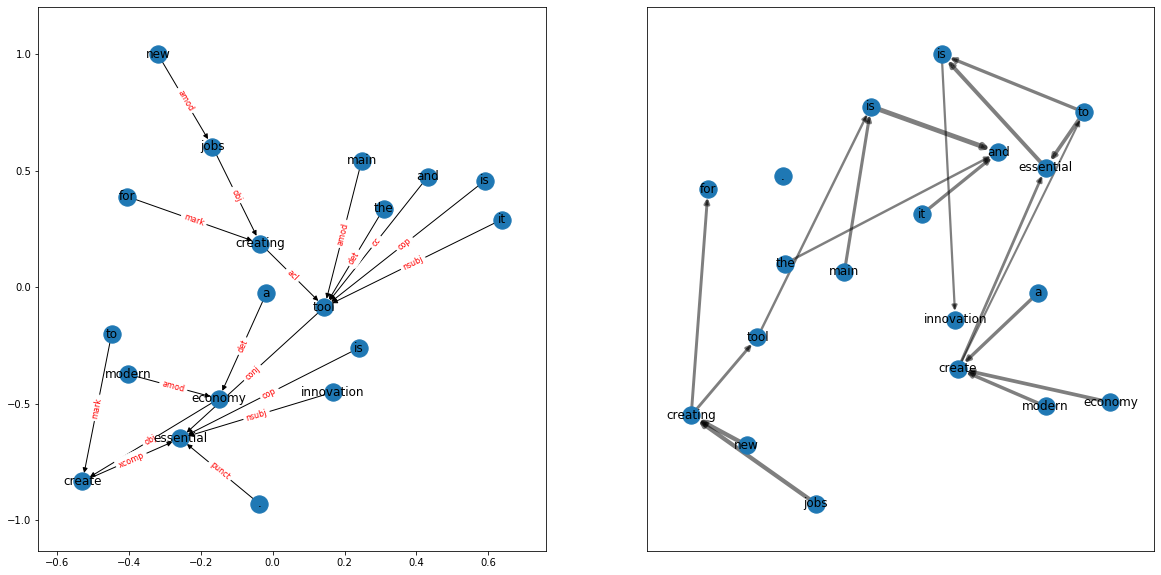

In [26]:
l = [7, 6, 3, 6, 4, 5, 3]
h = [ 9,  9, 11, 10,  6,  3,  8]
sentences = draw_graphs(l,h,0.2,169)

### Detrminers

1it [00:00,  3.85it/s]


960
i fully agree too with the proposal to include the online distribution of drugs in the directive .


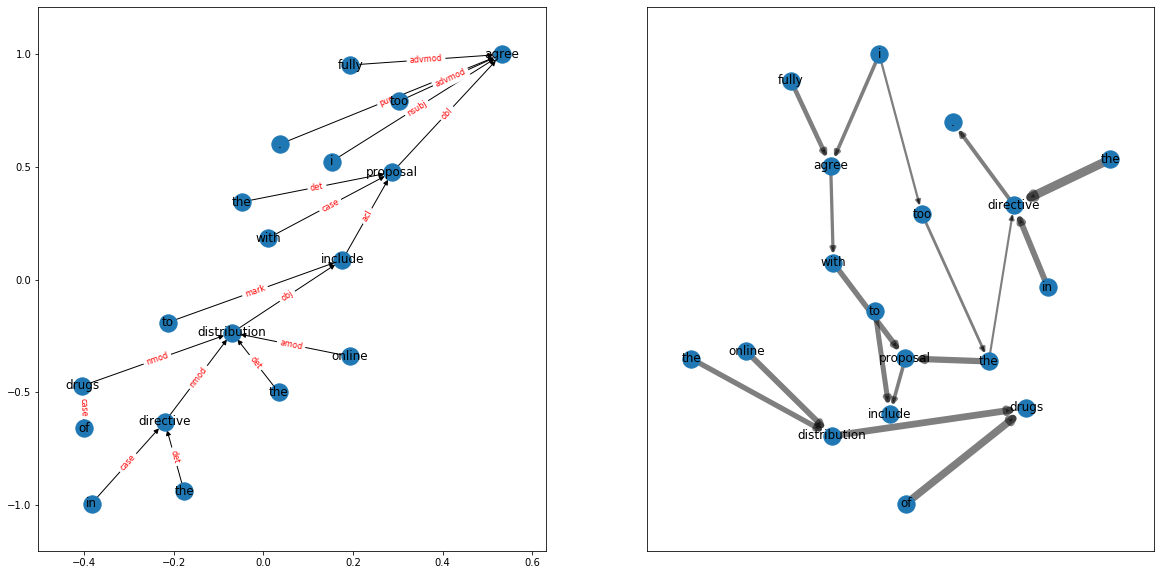

In [24]:
l = [7, 3, 4, 8]
h  = [10,  9,  5, 10]
sentences = draw_graphs(l,h,0.2,960)

# All

1it [00:00,  4.92it/s]


182
the position of the european parliament on terrorism is equally clear .


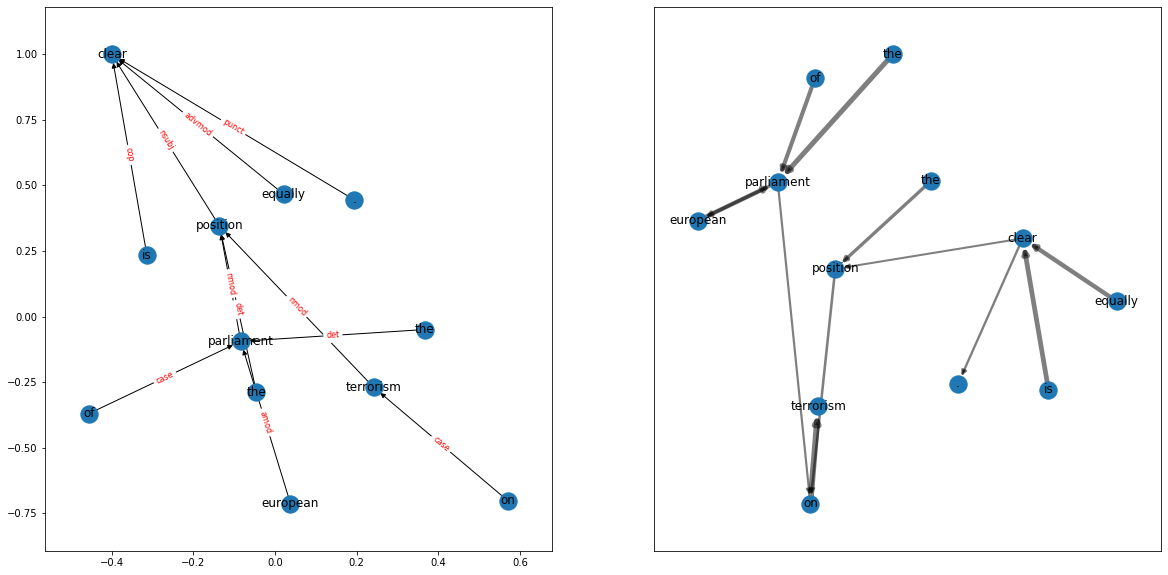

In [25]:
l = [3, 7, 6, 8, 4, 3, 0, 0]
h  = [ 9, 10,  5,  5,  5, 10,  8, 11]
sentences = draw_graphs(l,h,0.2,182)